### Before continuing, make sure you have Wiki DB installed and in the same directory as this program. See README for link

## Description of Data Set and CNN goal
The Convolutional Neural Network (CNN) built in this project aims to recognize and classify images of faces based on the provided metadata. <br>
Specifically, the CNN will be trained to:
Identify the Gender and Predict the Age of a person based on their face.

## Import Dependencies 

In [25]:
import scipy.io
import os
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import splitfolders
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from keras.models import Model




## Load Relevant Metadata

In [26]:
# Path to the local dataset directory
import numpy as np


data_dir = './wiki'

# Path to the metadata file
metadata_file = os.path.join(data_dir, 'wiki.mat')

# Load the metadata from the .mat file
metadata = scipy.io.loadmat(metadata_file)
# Extract the relevant metadata
wiki_data = metadata['wiki'][0, 0]
all_image_paths = wiki_data['full_path'][0]
print(all_image_paths)
names = wiki_data['name'][0]
genders = wiki_data['gender'][0]
birthdates = wiki_data['dob'][0]
photo_taken = wiki_data['photo_taken'][0]

# Calculate age
# Function to convert MATLAB serial date number to a readable date
def convert_dob(dob):
    reference_date = datetime(1, 1, 1)
    days_since_reference = int(dob)
    actual_date = reference_date + timedelta(days=days_since_reference - 366)
    return actual_date.strftime("%Y-%m-%d")  # Format as Year-Month-Day

# Calculate ages
ages = []
for dob, photo_year in zip(birthdates, photo_taken):
    birthdate = convert_dob(dob)
    age = photo_year - int(birthdate[:4])

    ages.append(age)

ages = np.array(ages)
# MATLAB's reference date (0 days since year 0)
reference_date = datetime(1, 1, 1)



[array(['17/10000217_1981-05-05_2009.jpg'], dtype='<U31')
 array(['48/10000548_1925-04-04_1964.jpg'], dtype='<U31')
 array(['12/100012_1948-07-03_2008.jpg'], dtype='<U29') ...
 array(['09/9998109_1972-12-27_2013.jpg'], dtype='<U30')
 array(['00/9999400_1981-12-13_2011.jpg'], dtype='<U30')
 array(['80/999980_1954-06-11_2008.jpg'], dtype='<U29')]


## Visualize 5 examples 

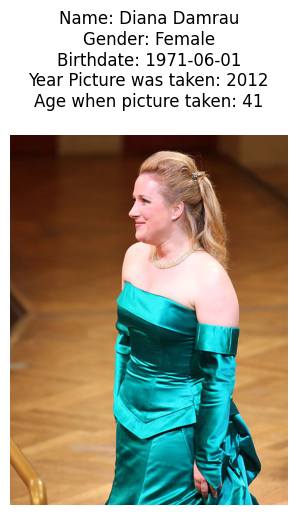

In [27]:

# Function to display an image with its metadata
def display_image_with_metadata(image_path, name, gender, dob, photo_taken, age):
    # Construct the full image path
    full_image_path = os.path.join(data_dir, image_path[0])
    birthdate_str = convert_dob(dob)

    # Open and display the image
    image = Image.open(full_image_path)
    plt.imshow(image)
    plt.imshow(image)
    title = (f"Name: {name[0]}\n"
            f"Gender: {'Male' if gender == 1 else 'Female' }\n"
             f"Birthdate: {birthdate_str}\n"
             f"Year Picture was taken: {photo_taken}\n"
             # Can be off by 1 year, since db does not have month/day picture was taken
             f"Age when picture taken: {age}\n"
             )
    plt.title(title)
    plt.axis('off')
    # plt.show()

# Display a few images with their metadata
for i in range(5):
    display_image_with_metadata(all_image_paths[i], names[i], genders[i], birthdates[i], photo_taken[i], ages[i])
    

## Split Data


In [28]:
# Split data between training and testing
# Check if the directory with split data already exists
if not os.path.exists("./wiki_split_data"):
    # Split data between training and testing
    splitfolders.ratio('./wiki', output="./wiki_split_data", seed=1337, ratio=(0.7, 0.15, 0.15))


## Prepare data for model

In [30]:
import os
import numpy as np
import scipy.io
from datetime import datetime, timedelta

# Function to get all image paths in a directory
def get_image_paths(directory):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Function to extract labels based on image paths
def extract_labels(image_paths, metadata_dict):
    extracted_ages = []
    extracted_genders = []
    for path in image_paths:
        file_name = os.path.basename(path)
        if file_name in metadata_dict:
            metadata = metadata_dict[file_name]
            extracted_ages.append(metadata['age'])
            extracted_genders.append(metadata['gender'])
        else:
            print(f'No match found for: {path}')
    return np.array(extracted_ages), np.array(extracted_genders)


# Create a mapping from file paths to metadata
metadata_dict = {}
for path, age, gender in zip(image_paths, ages, genders):
    file_name = os.path.basename(path[0])
    metadata_dict[file_name] = {'age': age, 'gender': gender}

# Get image paths for train, validation, and test datasets
train_image_paths = get_image_paths('./wiki_split_data/train')
val_image_paths = get_image_paths('./wiki_split_data/val')
test_image_paths = get_image_paths('./wiki_split_data/test')

print("Train Image Paths:", train_image_paths[:5])  # Print first 5 paths for verification
print("Validation Image Paths:", val_image_paths[:5])  # Print first 5 paths for verification
print("Test Image Paths:", test_image_paths[:5])  # Print first 5 paths for verification

# Extract labels for train, validation, and test datasets
y_train_ages, y_train_genders = extract_labels(train_image_paths, metadata_dict)
y_val_ages, y_val_genders = extract_labels(val_image_paths, metadata_dict)
y_test_ages, y_test_genders = extract_labels(test_image_paths, metadata_dict)

# Print shapes to confirm
print(f'y_train_ages shape: {y_train_ages.shape}')
print(f'y_train_genders shape: {y_train_genders.shape}')
print(f'y_val_ages shape: {y_val_ages.shape}')
print(f'y_val_genders shape: {y_val_genders.shape}')
print(f'y_test_ages shape: {y_test_ages.shape}')
print(f'y_test_genders shape: {y_test_genders.shape}')

Train Image Paths: ['./wiki_split_data/train/61/2399661_1977-09-02_2008.jpg', './wiki_split_data/train/61/9494361_1962-04-21_1994.jpg', './wiki_split_data/train/61/44438061_1937-11-14_1969.jpg', './wiki_split_data/train/61/41899761_1989-10-06_2012.jpg', './wiki_split_data/train/61/37117161_1956-11-28_1986.jpg']
Validation Image Paths: ['./wiki_split_data/val/61/19242061_1982-08-16_2009.jpg', './wiki_split_data/val/61/8794261_1970-10-06_2011.jpg', './wiki_split_data/val/61/2483261_1981-02-19_2012.jpg', './wiki_split_data/val/61/4293661_1967-05-16_1995.jpg', './wiki_split_data/val/61/36075861_1983-09-23_2014.jpg']
Test Image Paths: ['./wiki_split_data/test/61/37699961_1890-12-11_1947.jpg', './wiki_split_data/test/61/2075561_1966-06-14_2010.jpg', './wiki_split_data/test/61/22156261_1992-10-16_2011.jpg', './wiki_split_data/test/61/328261_1946-08-06_2007.jpg', './wiki_split_data/test/61/382561_1961-10-09_2009.jpg']
y_train_ages shape: (43581,)
y_train_genders shape: (43581,)
y_val_ages shap

## Build and Train model

In [ ]:
# Input layer
input_layer = Input(shape=(64, 64, 3))

# Shared layers
x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu')(input_layer)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)

# Output layers
age_output = Dense(units=1, activation='linear', name='age_output')(x)  # Regression for age
gender_output = Dense(units=1, activation='sigmoid', name='gender_output')(x)  # Binary classification for gender

# Define the model
model = Model(inputs=input_layer, outputs=[age_output, gender_output])

# Print the model summary
model.summary()

# Train the model